In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def residual_block(x, filters):
    shortcut = x
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    
    return x


def attention_gate(x, g, filters):
    x1 = layers.Conv2D(filters, (1, 1), padding='same')(x)
    g1 = layers.Conv2D(filters, (1, 1), padding='same')(g)
    
    out = layers.add([x1, g1])
    out = layers.ReLU()(out)
    out = layers.Conv2D(1, (1, 1), padding='same')(out)
    out = layers.Activation('sigmoid')(out)
    
    return layers.multiply([x, out])


2024-08-18 14:36:43.636244: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-18 14:36:45.397178: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-08-18 14:36:45.397308: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [2]:
def unet_v3(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Downsampling
    c1 = residual_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = residual_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = residual_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = residual_block(p3, 512)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = residual_block(p4, 1024)
    
    # Upsampling with attention
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = attention_gate(c4, u6, 512)
    u6 = layers.concatenate([u6, c4])
    c6 = residual_block(u6, 512)
    
    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = attention_gate(c3, u7, 256)
    u7 = layers.concatenate([u7, c3])
    c7 = residual_block(u7, 256)
    
    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = attention_gate(c2, u8, 128)
    u8 = layers.concatenate([u8, c2])
    c8 = residual_block(u8, 128)
    
    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = attention_gate(c1, u9, 64)
    u9 = layers.concatenate([u9, c1])
    c9 = residual_block(u9, 64)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

2024-08-18 14:36:50.565198: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-18 14:36:50.597786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-18 14:36:50.601168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-18 14:36:50.605354: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [3]:
import numpy as np

train_dataset = np.load("../../numpy_arr_data/train_img.npy")
mask_dataset = np.load("../../numpy_arr_data/vegetation_mask_img.npy")

# Prepare your dataset as before
train_images = [tf.image.resize(images, (128, 128)).numpy() for images in train_dataset]
train_masks = [tf.image.resize(mask, (128, 128)).numpy() for mask in mask_dataset]

In [4]:
# Convert lists to numpy arrays
train_images = np.array(train_images)
train_masks = np.array(train_masks)

train_images.shape, train_masks.shape

((2975, 128, 128, 3), (2975, 128, 128, 3))

In [53]:
import numpy as np
import matplotlib.pyplot as plt

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

gray_mask = []
for mask in train_masks:
    mask = rgb2gray(mask)
    mask[mask<0.5]=0
    mask[mask>=0.5]=1
    gray_mask.append(mask) 
    
gray_mask = np.array(gray_mask)
gray_mask = gray_mask[...,np.newaxis]
    
    
gray_image = []
for image in train_images:
    image = rgb2gray(image)
    gray_image.append(image) 
    
gray_image = np.array(gray_image)
gray_image = gray_image[...,np.newaxis]

In [54]:
gray_image.shape, gray_mask.shape

((2975, 128, 128, 1), (2975, 128, 128, 1))

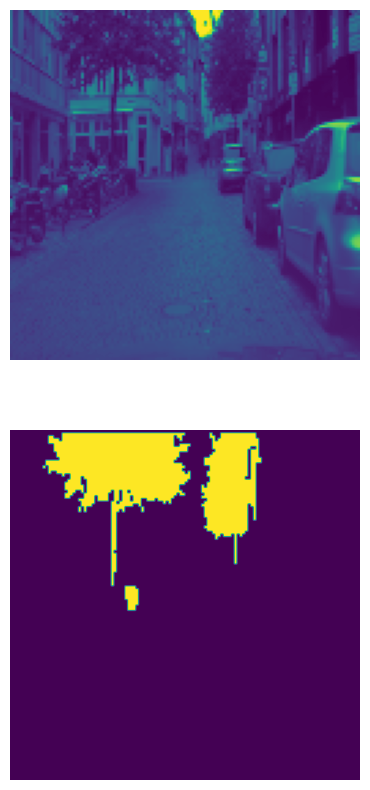

In [55]:
import matplotlib.pyplot as plt

# Example list of images (replace with your actual images)
images = [gray_image[0], gray_mask[0]]  # Replace with your actual images

# Number of images
num_images = len(images)

# Determine the grid size (e.g., 2 rows, 3 columns for 6 images)
rows = 2
cols = (num_images + 1) // 2

# Create a figure
plt.figure(figsize=(10, 10))

# Loop through the images and add each to a subplot
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i])
    plt.axis('off')  # Hide the axis

# Show the plot
plt.show()

In [57]:
from tensorflow.keras.callbacks import EarlyStopping
# Step 3: Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [58]:
# Clear the session to avoid any potential issues with model state
tf.keras.backend.clear_session()

# Define and compile the model
model = unet_v3(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(gray_image, gray_mask, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
84/84 [==============================] - 67s 605ms/step - loss: 0.2313 - accuracy: 0.9019 - val_loss: 0.4145 - val_accuracy: 0.8772
Epoch 2/50
84/84 [==============================] - 49s 585ms/step - loss: 0.1450 - accuracy: 0.9434 - val_loss: 0.6146 - val_accuracy: 0.8761
Epoch 3/50
84/84 [==============================] - 49s 587ms/step - loss: 0.1264 - accuracy: 0.9510 - val_loss: 0.5703 - val_accuracy: 0.8769
Epoch 4/50
84/84 [==============================] - 49s 587ms/step - loss: 0.1149 - accuracy: 0.9555 - val_loss: 0.2089 - val_accuracy: 0.9155
Epoch 5/50
84/84 [==============================] - 49s 587ms/step - loss: 0.1102 - accuracy: 0.9573 - val_loss: 0.1604 - val_accuracy: 0.9313
Epoch 6/50
84/84 [==============================] - 49s 587ms/step - loss: 0.1089 - accuracy: 0.9577 - val_loss: 0.1323 - val_accuracy: 0.9455
Epoch 7/50
84/84 [==============================] - 49s 588ms/step - loss: 0.1035 - accuracy: 0.9598 - val_loss: 0.1040 - val_accuracy: 0.9599

In [59]:
model.save('../model/mobile_unet.keras')

### Testing Unet v3 model

In [1]:
import numpy as  np
import tensorflow as tf
import matplotlib.pyplot as plt

model_unet_v3 = tf.keras.models.load_model("../model/mobile_unet.keras")
test_image = np.load("../../numpy_arr_data/test_img.npy")
mask_image = np.load("../../numpy_arr_data/test_vegetation_mask_gray_img.npy")
mask_image = mask_image[...,np.newaxis]
test_image = [tf.image.resize(images, (224, 224)).numpy() for images in test_image]
mask_image = [tf.image.resize(mask, (224, 224)).numpy() for mask in mask_image]

test_image = np.array(test_image)
mask_image = np.array(mask_image)
print(test_image.shape, mask_image.shape)

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    
gray_image_test = []
for image in test_image:
    image = rgb2gray(image)
    gray_image_test.append(image) 
    
gray_image_test = np.array(gray_image_test)
gray_image_test = gray_image_test[...,np.newaxis]

2024-08-18 17:52:40.276827: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-18 17:52:41.166993: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-08-18 17:52:41.167107: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [67]:
gray_image_test.shape

(500, 128, 128, 1)

In [69]:
predicted = model.predict(gray_image_test, verbose=1)

16/16 [==============================] - 3s 176ms/step


In [70]:
predicted.shape

(500, 128, 128, 1)

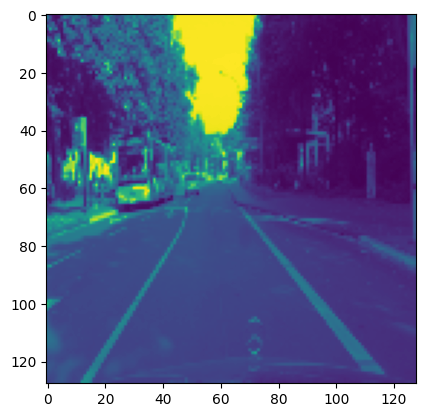

In [68]:
plt.imshow(gray_image_test[0])

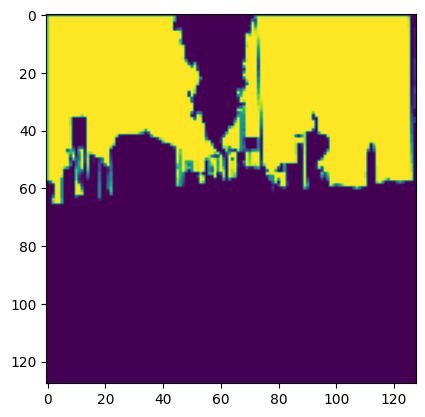

In [71]:
plt.imshow(mask_image[0])

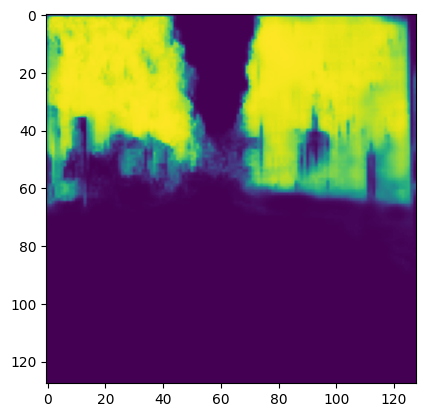

In [73]:
plt.imshow(predicted[0])

In [74]:
pred_mask = []
for mask in predicted:
    # mask = rgb2gray(mask)
    mask[mask<0.5]=0
    mask[mask>=0.5]=1
    pred_mask.append(mask) 

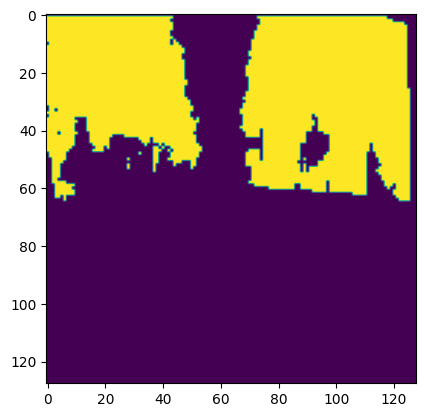

In [75]:
plt.imshow(pred_mask[0])

In [76]:
def calculating_iou(true_mask, pred_mask):
    arr_iou=[]
    for i in range(len(true_mask)):
        intersection = np.logical_and(true_mask[i],pred_mask[i])
        union = np.logical_or(true_mask[i], pred_mask[i])
        iou_score = np.sum(intersection) / np.sum(union)
        arr_iou.append(iou_score)
    arr_iou=np.array(arr_iou)
    arr_iou= np.nan_to_num(arr_iou, copy=True, nan=1.0)
    mean_iou=arr_iou.mean()
    return mean_iou

In [77]:
calculating_iou(mask_image, pred_mask)

/var/tmp/ipykernel_29425/1812405044.py:6: RuntimeWarning: invalid value encountered in scalar divide
  iou_score = np.sum(intersection) / np.sum(union)


0.5985936507352619